CNN-v1-b
This notebook runs the image generator version of the CNN (based on E. Culhane cnn codes) and uses both the microsoft azure VM for data storage/access, and for running the code. The CNN is trained using labeled NAAMES data.
Changes over CNN-v1: saving of model labeling info in a csv file so that predictions made with save model weights and structure can be recovered. The model itself is the same (create_cnn_model_A1 in ml_models.py)
A. Chase, June 2023

In [42]:
# import libraries

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import imageio
import cv2
import getpass
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
import tensorflow.keras as keras
import tensorflow as tf
from keras.callbacks import Callback
import datetime
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import sys
sys.path.append('../')
import imp

import data_utils as du
import ml_models

In [43]:
# read in the csv file of all image lables and filenames. this file is specific to NAAMES data (all four cruises)

csv_path = '/home/azureuser/data/image-file-directory.csv'

df = pd.read_csv(csv_path)
df

,file_name,class_raw,high_group,missing_high_group,id,lat,long,Area,Biovolume,ConvexArea,...,ScatInt,FluoInt,ScatPeak,FluoPeak,NumberOfROIinTrigger,missing_meta_data,ESDA_exclude,excluded_1,set,binary_label
0,IFCB107D20151104T112022P00433_Unicellular.png,Unicellular,Other,False,IFCB107D20151104T112022P00433,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,True,False,1,train,plankton
1,IFCB107D20151104T114135P00194_Unicellular.png,Unicellular,Other,False,IFCB107D20151104T114135P00194,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,True,False,1,train,plankton
2,IFCB107D20151104T114135P00246_Unicellular.png,Unicellular,Other,False,IFCB107D20151104T114135P00246,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,True,False,1,train,plankton
3,IFCB107D20151104T124515P00027_Unicellular.png,Unicellular,Other,False,IFCB107D20151104T124515P00027,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,True,False,1,train,plankton
4,IFCB107D20151105T174918P00074_Dinophyceae.png,Dinophyceae,Dinoflagellate,False,IFCB107D20151105T174918P00074,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,True,False,1,train,plankton
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1998895,IFCB107D20180412T010113P00020_Ceratium.png,Ceratium,Dinoflagellate,False,IFCB107D20180412T010113P00020,40.348,-68.296,1507.093426,20001.839825,2501.816609,...,1.09682,0.36801,3.33541,1.37789,1.0,False,False,0,train,plankton
1998896,IFCB107D20180412T012434P00137_Ditylum.png,Ditylum,Diatom,False,IFCB107D20180412T012434P00137,40.324,-68.387,4811.591696,91203.058213,6707.612457,...,3.49742,1.77298,3.35693,3.31523,1.0,False,False,0,train,plankton
1998897,IFCB107D20180412T012434P00348_Ditylum.png,Ditylum,Diatom,False,IFCB107D20180412T012434P00348,40.324,-68.387,2446.626298,30443.529921,3317.560554,...,2.46922,0.90272,3.35900,2.21282,1.0,False,False,0,train,plankton
1998898,IFCB107D20180412T021117P00330_Ceratium.png,Ceratium,Dinoflagellate,False,IFCB107D20180412T021117P00330,40.273,-68.571,1500.951557,19808.704267,2787.802768,...,0.61201,0.04541,2.85538,0.37142,1.0,False,False,0,train,plankton


In [44]:
# add a column of the png path to the df dataframe
df['png_path'] = df['id'].apply(lambda row : du.buildPNGsName(row))

In [45]:
# add a column called full_path
df['full_path'] = df['png_path'].apply(lambda row : os.path.join('/home/azureuser/data/NAAMES_ml/', row))

In [46]:
# look at summary of all images

summary = df.groupby('high_group').agg({'png_path' : 'count'})
summary 

,png_path
high_group,
Artefact,991
Chloro,12342
Chryso,17
Cilliate,3718
Corrupt,117523
Crypto,45070
Cyanobacteria,48
Diatom,222838
Dictyo,13513


In [47]:
# restructure lables to handle very small groups and to
# use 'null' as a catch-all for bad focus, artefact, non-living
# (note that 'Corrupt' is bad focus mainly)

class_dict = {'Artefact' : 'null',
            'Chryso' : 'Other', 
            'Corrupt' : 'null',
            'Cyanobacteria' : 'Other',
            'Multiple' : 'Other',
            'Not living' : 'null', 
            'Rhizaria' : 'Other',
             'Zoo' : 'Other'}

In [48]:
df['high_group'] = df.apply(lambda row: du.change_class(row, class_dict), axis=1)

In [49]:
summary = df.groupby('high_group').agg({'png_path' : 'count'})
summary 

,png_path
high_group,
Chloro,12342
Cilliate,3718
Crypto,45070
Diatom,222838
Dictyo,13513
Dinoflagellate,140633
Eugleno,66002
Other,1268485
Prymnesio,22119


In [50]:
# split the data for testing and training
train, validation = train_test_split(df, test_size=0.2)

In [51]:
# look at training distribution 

train_summary = train.groupby('high_group').agg({'png_path' : 'count'})
train_summary

,png_path
high_group,
Chloro,9931
Cilliate,2996
Crypto,36017
Diatom,178253
Dictyo,10876
Dinoflagellate,112644
Eugleno,52906
Other,1014339
Prymnesio,17676


In [52]:
# randomly downsample 'Other' images keeping 200k of >1 million 

other = train.loc[train['high_group'] == 'Other']
not_other = train.loc[train['high_group'] != 'Other']
other_keep = other.sample(n=200000)
train = pd.concat([not_other, other_keep])

In [12]:
# randomly downsample all groups to reduce total number of images used in network training. Try 5k each (when possible)

# other = train.loc[train['high_group'] == 'Chloro']
# not_other = train.loc[train['high_group'] != 'Chloro']
# other_keep = other.sample(n=5000)
# train = pd.concat([not_other, other_keep])

# other = train.loc[train['high_group'] == 'Crypto']
# not_other = train.loc[train['high_group'] != 'Crypto']
# other_keep = other.sample(n=5000)
# train = pd.concat([not_other, other_keep])

# other = train.loc[train['high_group'] == 'Diatom']
# not_other = train.loc[train['high_group'] != 'Diatom']
# other_keep = other.sample(n=5000)
# train = pd.concat([not_other, other_keep])

# other = train.loc[train['high_group'] == 'Dictyo']
# not_other = train.loc[train['high_group'] != 'Dictyo']
# other_keep = other.sample(n=5000)
# train = pd.concat([not_other, other_keep])

# other = train.loc[train['high_group'] == 'Dinoflagellate']
# not_other = train.loc[train['high_group'] != 'Dinoflagellate']
# other_keep = other.sample(n=5000)
# train = pd.concat([not_other, other_keep])

# other = train.loc[train['high_group'] == 'Eugleno']
# not_other = train.loc[train['high_group'] != 'Eugleno']
# other_keep = other.sample(n=5000)
# train = pd.concat([not_other, other_keep])

# other = train.loc[train['high_group'] == 'Other']
# not_other = train.loc[train['high_group'] != 'Other']
# other_keep = other.sample(n=5000)
# train = pd.concat([not_other, other_keep])

# other = train.loc[train['high_group'] == 'Prymnesio']
# not_other = train.loc[train['high_group'] != 'Prymnesio']
# other_keep = other.sample(n=5000)
# train = pd.concat([not_other, other_keep])

# other = train.loc[train['high_group'] == 'null']
# not_other = train.loc[train['high_group'] != 'null']
# other_keep = other.sample(n=5000)
# train = pd.concat([not_other, other_keep])

In [53]:
# look at new distribution of training 

train_summary = train.groupby('high_group').agg({'png_path' : 'count'})
train_summary

,png_path
high_group,
Chloro,9931
Cilliate,2996
Crypto,36017
Diatom,178253
Dictyo,10876
Dinoflagellate,112644
Eugleno,52906
Other,200000
Prymnesio,17676


In [54]:
# one hot encode the labels 

lb = LabelBinarizer()
labels = set(df.high_group)
lb.fit(list(labels))
batch_size = 100

In [55]:
# instantiate generators 

trainGen = du.image_generator(train, batch_size, lb)
validationGen = du.image_generator(validation, batch_size, lb)

In [56]:
# define CNN model

ml_models.create_cnn_model_A1

<function ml_models.create_cnn_model_A1(width, height, depth, filters=(32, 16, 64, 32, 128, 128, 64, 256, 256, 128), regress=False)>

In [57]:
# define and compile cnn

cnn = ml_models.create_cnn_model_A1(128, 128, 1, regress=False)
x = Dense(1000, activation="relu")(cnn.output)
x = Dropout(rate=0.1)(x)
x = Dense(len(labels), activation="softmax")(x)
model = Model(inputs=cnn.input, outputs=x)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [58]:
%%time
# train model and save history object 

totalTrain = len(train)
totalVal = len(validation)

' training in smaller increments to monitor progress '

print("[INFO] training simple network...")
H = model.fit(
    trainGen,
    steps_per_epoch=totalTrain // batch_size,
    validation_data=validationGen,
    validation_steps=totalVal // batch_size,
    epochs=16)

[INFO] training simple network...
Epoch 1/16
7847/7847 [==============================] - 14151s 2s/step - loss: 0.5245 - accuracy: 0.8242 - val_loss: 0.6726 - val_accuracy: 0.7468
Epoch 2/16
7847/7847 [==============================] - 14155s 2s/step - loss: 0.3749 - accuracy: 0.8721 - val_loss: 0.5413 - val_accuracy: 0.7924
Epoch 3/16
7847/7847 [==============================] - 13674s 2s/step - loss: 0.3357 - accuracy: 0.8843 - val_loss: 0.4345 - val_accuracy: 0.8425
Epoch 4/16
7847/7847 [==============================] - 13741s 2s/step - loss: 0.3132 - accuracy: 0.8914 - val_loss: 0.5179 - val_accuracy: 0.8028
Epoch 5/16
7847/7847 [==============================] - 13581s 2s/step - loss: 0.2955 - accuracy: 0.8965 - val_loss: 0.7707 - val_accuracy: 0.6924
Epoch 6/16
7137/7847 [==========================>...] - ETA: 18:52 - loss: 0.2821 - accuracy: 0.9008


Bad pipe message: %s [b' \x158\x9ccu]\x9c\x8d\xe6cE\xe2\x06K\xbd\xbcl zf\xb2f\xc5j\xe5\x9f\xa9\xd1\xe6j\xedLa\xc3{z\x85\xa3I\xbe\x12\xccU\xca\x9b]+\xf1\x12\x98\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d']
Bad pipe message: %s [b'JR\xee\xb0\x7fq\xca\x81x\x05.$9K\x02\xf7\x11\x0e <xR\x97[,X\xb4\xb8r\xc9\xe9\xa2B\xd5\xd3\xe8\x8c\xf2kU\x17/r\x9cE\xbby\xb7\xc8_V\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00']
Bad pipe message: %s [b'\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00']
Bad pipe message: %s [b'\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06\x01']
Bad pipe message: %s [b'\x00\x94F\xea{T\x9dn\x02\xd1\xce),G\xffb\xc8I\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\x

7847/7847 [==============================] - 13556s 2s/step - loss: 0.2820 - accuracy: 0.9008 - val_loss: 0.8904 - val_accuracy: 0.6254
Epoch 7/16
7847/7847 [==============================] - 13469s 2s/step - loss: 0.2697 - accuracy: 0.9045 - val_loss: 0.4118 - val_accuracy: 0.8409
Epoch 8/16
7847/7847 [==============================] - 13584s 2s/step - loss: 0.2582 - accuracy: 0.9081 - val_loss: 0.4016 - val_accuracy: 0.8414
Epoch 9/16
7847/7847 [==============================] - 13497s 2s/step - loss: 0.2460 - accuracy: 0.9117 - val_loss: 0.4579 - val_accuracy: 0.8312
Epoch 10/16
7847/7847 [==============================] - 13566s 2s/step - loss: 0.2358 - accuracy: 0.9149 - val_loss: 0.4102 - val_accuracy: 0.8427
Epoch 11/16
7847/7847 [==============================] - 13636s 2s/step - loss: 0.2254 - accuracy: 0.9180 - val_loss: 0.4306 - val_accuracy: 0.8344
Epoch 12/16
7847/7847 [==============================] - 14174s 2s/step - loss: 0.2151 - accuracy: 0.9214 - val_loss: 0.4448 - 

In [59]:
# save model weights and structure from history object / reload and make predictions 

''' save model and weights '''
model_json = model.to_json()
with open("model-cnn-v1-b3.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model-cnn-v1-b3.h5")
print("Saved model to disk")


Saved model to disk


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


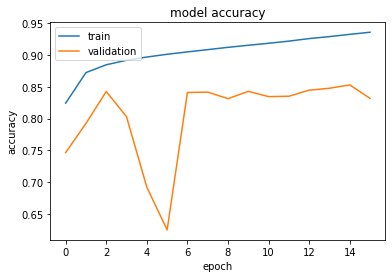

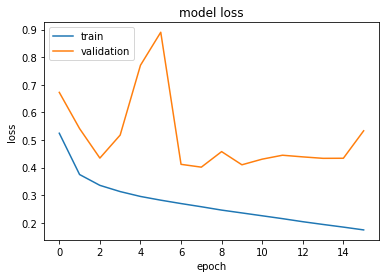

In [60]:
# plot info from model history object 

# list all data in history
print(H.history.keys())

# summarize history for accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [61]:
# predicting with the trained model before exporting & reloading etc

test_split = np.array_split(validation, 10)
test_preds = []
n = 1
for df in test_split: 
    labels = df['high_group'].values
    test_labels = lb.fit_transform(labels)
    v_dat = df.drop(['full_path', 'high_group'], axis=1).values
    image_data = []
    idx_to_delete = []
    for i in range(len(df)): 
        row = df.iloc[i]
        input_path = row['full_path'] 
        image_data.append(du.preprocess_input(imageio.imread(input_path)))
        # handling reading errors (some batches will be shorter than batch size!!)
        # try:
        #     image_data.append(preprocess_input(imageio.imread(input_path)))
        # except Exception as e:
        #     idx_to_delete.append(i)
        #     print('Failed file')
        #     print(input_path)
        #             #pass
        #         # try putting this line in the loop at the level of the except
        #     labels = np.delete(labels, idx_to_delete, 0)       
        #
    test_input = np.array(image_data)
    predictions = model.predict(test_input)
    pred_frame = pd.DataFrame(predictions)
    pred_frame['full_path'] = df['full_path'].values.tolist()
    top_1 = [np.argmax(i) for i in predictions]
    df['pred_label'] = top_1
    df['true_label'] = [np.argmax(i) for i in test_labels]
    df['is_correct'] = df.apply(lambda row: du.is_correct(row), axis=1)
    df_out = pd.merge(df, pred_frame, on = 'full_path', how='left')
    test_preds.append(df_out)
    print('completed ' + str(n) + ' of 10 testing subsets')
    n +=1 
    del image_data



test_eval = pd.concat(test_preds)

if len(test_eval) == len(validation):
    print('generated predictions for all examples in testing dataset')

completed 1 of 10 testing subsets
completed 2 of 10 testing subsets
completed 3 of 10 testing subsets
completed 4 of 10 testing subsets
completed 5 of 10 testing subsets
completed 6 of 10 testing subsets
completed 7 of 10 testing subsets
completed 8 of 10 testing subsets
completed 9 of 10 testing subsets
completed 10 of 10 testing subsets
generated predictions for all examples in testing dataset


In [62]:
input_path

'/home/azureuser/data/NAAMES_ml/D20160525T034049_IFCB107/IFCB107D20160525T034049P00438.png'

In [63]:
# look at history objct for training hueristics

print(H.history.keys())
H.history['accuracy']

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


[0.8242219686508179,
 0.8720504641532898,
 0.8843239545822144,
 0.8913852572441101,
 0.8964700102806091,
 0.9007939100265503,
 0.9045278429985046,
 0.9080629348754883,
 0.9116758108139038,
 0.9149242043495178,
 0.9180247187614441,
 0.9214017987251282,
 0.9253829717636108,
 0.928496241569519,
 0.932033896446228,
 0.9353281259536743]

In [64]:
H.history['val_accuracy']

[0.7467750906944275,
 0.7924017906188965,
 0.8424668312072754,
 0.8027696013450623,
 0.6923567652702332,
 0.6254440546035767,
 0.8409056663513184,
 0.8414285778999329,
 0.8312334418296814,
 0.8426769971847534,
 0.834423303604126,
 0.8349762558937073,
 0.8445059061050415,
 0.8475231528282166,
 0.8527770638465881,
 0.8316712379455566]

In [66]:
# --
# obtain accruacy for final model prediction 

float(sum(test_eval.is_correct))/float(len(test_eval))

0.831672419830907

In [67]:
# make reference for reviewing by class model accuracy 

test_summ = test_eval[[ u'full_path', u'high_group', u'pred_label', u'true_label', u'is_correct',
                              0,                        1,
                              2,                        3,
                              4,                        5,
                              6,                        7,
                              8,                        9]]


In [69]:
def get_top_5(row):
    preds = [row[i] for i in range(10)]
    top_5 = sorted(zip(preds, range(10)), reverse=True)[:5]
    indices = [n[1] for n in top_5]
    if row['true_label'] in indices: 
        out = 1
    else: 
        out = 0
    return out

def get_percent(row, c): 
    val = row[c]
    return float(val) / float(row['n_obs'])



In [71]:
# add top 5 accuracy score to output & build by class summary frame

test_summ['top_5'] = test_summ.apply(lambda row: get_top_5(row), axis=1)

test_agg = test_summ.groupby('high_group').agg({'full_path' : 'count', 'is_correct' : 'sum', 'top_5' : 'sum'})
test_agg.reset_index(inplace=True)
test_agg.columns = ['high_group', 'top_1', 'top_5', 'n_obs']
test_agg['top_1_acc'] = test_agg.apply(lambda row: get_percent(row, 'top_1'), axis=1)
test_agg['top_5_acc'] = test_agg.apply(lambda row: get_percent(row, 'top_5'), axis=1)


test_summ.to_csv('./model-summary-cnn-v1-b3.csv', index=False)
test_agg.sort_values('top_1_acc', ascending=False)

/tmp/ipykernel_6221/4074149471.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_summ['top_5'] = test_summ.apply(lambda row: get_top_5(row), axis=1)


,high_group,top_1,top_5,n_obs,top_1_acc,top_5_acc
1,Cilliate,722,615,691,1.044863,0.890014
0,Chloro,2411,1846,2351,1.025521,0.785198
8,Prymnesio,4443,3294,4352,1.020910,0.756893
4,Dictyo,2637,2503,2602,1.013451,0.961952
2,Crypto,9053,8329,8933,1.013433,0.932386
6,Eugleno,13096,11820,12947,1.011508,0.912953
5,Dinoflagellate,27989,23755,27937,1.001861,0.850306
3,Diatom,44585,42684,44517,1.001528,0.958825
9,null,40698,36272,40678,1.000492,0.891686
7,Other,254146,201368,254142,1.000016,0.792344


In [75]:
predictions.shape

(39978, 10)

In [82]:
pred_frame

,0,1,2,3,4,5,6,7,8,9,full_path
0,8.788808e-05,1.044836e-11,2.288338e-06,1.460568e-04,5.931003e-07,6.557167e-03,6.113105e-06,0.954357,2.275486e-04,3.861572e-02,/home/azureuser/data/NAAMES_ml/D20160530T00372...
1,3.256217e-05,8.549365e-11,4.850801e-07,3.942768e-01,1.409225e-07,1.180000e-03,3.734580e-06,0.225990,1.386072e-04,3.783773e-01,/home/azureuser/data/NAAMES_ml/D20180405T00223...
2,1.509550e-04,4.006559e-08,5.253983e-07,2.351280e-05,3.922317e-05,8.805541e-05,1.607145e-09,0.172550,2.146365e-04,8.269328e-01,/home/azureuser/data/NAAMES_ml/D20170914T09270...
3,1.021523e-07,3.841918e-10,9.434665e-09,9.852543e-01,3.431013e-08,1.726928e-05,1.218422e-02,0.001003,4.055983e-04,1.135121e-03,/home/azureuser/data/NAAMES_ml/D20160517T07122...
4,3.343470e-05,2.607871e-16,6.982982e-08,5.635854e-05,1.013391e-11,2.858922e-02,9.157657e-06,0.970406,4.338525e-04,4.715165e-04,/home/azureuser/data/NAAMES_ml/D20160517T02520...
...,...,...,...,...,...,...,...,...,...,...,...
39973,6.013485e-13,3.751894e-26,3.330312e-09,7.386912e-06,3.777496e-13,6.410740e-06,9.999207e-01,0.000065,1.452780e-07,5.057208e-07,/home/azureuser/data/NAAMES_ml/D20160530T23394...
39974,7.562776e-08,1.580177e-10,2.543378e-09,1.973915e-06,4.075483e-10,9.998869e-01,1.908314e-09,0.000110,5.005263e-08,3.868345e-07,/home/azureuser/data/NAAMES_ml/D20160529T01183...
39975,5.158942e-07,7.589195e-09,5.717600e-09,2.155094e-05,9.907631e-07,1.271514e-05,1.036836e-10,0.015101,7.108635e-05,9.847918e-01,/home/azureuser/data/NAAMES_ml/D20160528T18364...
39976,4.261079e-08,9.153698e-30,4.726195e-11,1.692143e-08,7.329000e-19,2.060179e-07,3.326508e-17,0.999673,1.107582e-07,3.268361e-04,/home/azureuser/data/NAAMES_ml/D20180410T12230...
